Imported Libaries

In [1]:
import os
from sqlalchemy import create_engine

import inspect
from IPython.display import display as original_display

import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import numpy as np
from scipy.stats import zscore

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import warnings
warnings.filterwarnings('ignore')

Standard Functions

In [2]:
#Function to clean labels in any plot functions
def clean_label(label):
    return label.replace('_', ' ').title()
 
#Function for getting the name of a Dataframe
def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name
 
#Function to validate the data in a Dataframe
def validate_data(df, show_counts=True):
    df_name = get_var_name(df)
    print(f'#########################################################################################################################################################################################\nDataFrame: {df_name}')
    #snapshot the dataset
    display(df)
    #check for unique values
    unique_counts = pd.DataFrame(df.nunique())
    unique_counts = unique_counts.reset_index().rename(columns={0:'No. of Unique Values', 'index':'Field Name'})
    print("Unique values per field:")
    pd.set_option('display.max_rows', None)
    display(unique_counts)
    pd.reset_option('display.max_rows')
    #checking for duplicates
    duplicate_count = df.duplicated().sum()
    print("\nNumber of duplicate rows:")
    print(duplicate_count,'\n')
    info = df.info(show_counts=show_counts)
    display(info)
    #summary stats
    print("\nSummary statistics:")
    display(df.describe())
    print('End of data validation\n#########################################################################################################################################################################################\n')
 
#Function to provide list for data sources as a dataframe when conducting analysis
def header_list(df):
    df_list_ = df.copy()
    df_list = df_list_.columns.tolist()
    df_list = pd.DataFrame(df_list)
    new_header = df_list.iloc[0]  # Get the first row for the header
    df_list = df_list[1:]  # Take the data less the header row
    df_list.columns = new_header  # Set the header row as the df header
    df_list.reset_index(drop=True, inplace=True)  # Reset index
   
    return df_list
 
def query_data(schema, data):
    # Define the SQL query
    query = f'SELECT * FROM [{schema}].[{data}]'
 
    # Load data into DataFrame
    df = pd.read_sql(query, engine)
 
    print(f'Successfully imported {data}')
    # Display the DataFrame
    return df

def display(df):
    # Attempt to get the name of the DataFrame from the caller's local variables
    frame = inspect.currentframe().f_back
    # Attempt to find the variable name corresponding to the DataFrame
    name = "Unnamed DataFrame"
    for var_name, var_value in frame.f_locals.items():
        if var_value is df:
            name = var_name
            break
 
    # If the name is not in the list to be excluded, print it
    if name not in {'df', 'Unnamed DataFrame', 'unique_counts'}:
        print(f"DataFrame: {name}")
    # Always display the DataFrame regardless of the name
    original_display(df)

def unique_values(df, display_df=True):
    # Extract unique values for each field and store them in a dictionary
    unique_values = {col: df[col].unique() for col in df.columns}
    # Find the maximum number of unique values
    max_length = max(len(values) for values in unique_values.values())
    # Create a dictionary for the new DataFrame with padded None values
    unique_df_data = {}
    for col, values in unique_values.items():
        unique_df_data[col] = list(values) + [None] * (max_length - len(values))
    # Create the new DataFrame
    unique_df = pd.DataFrame(unique_df_data)
    if display_df == True:
        # Set display options to show all rows and display the DataFrame
        pd.set_option('display.max_rows', None)
        display(unique_df.head(100))
        # Reset display options back to default
        pd.reset_option('display.max_rows')

def export_to_csv(df):
    df_name = get_var_name(df)
    # Specify the directory and filename
    directory = r"C:\Users\jf79\OneDrive - Office Shared Service\Documents\H&F Analysis\Python CSV Repositry"
    file_path = f'{directory}\\{df_name}.csv'
    # Export the DataFrame to the specified directory
    df.to_csv(file_path, index=False)
    print(f'Successfully exported {df_name} to CSV')

Specific Functions for this Script

In [3]:
def detect_anomalies(df, category, std=3, day_night=False,agg=False):
    if agg:
        agg = f'{agg}'
    else:
        agg='sum'
    categories = [
        'count_date',f'spend_{category}',
        'zscore','is_anomaly?'
    ]
    if day_night:
        categories = [
            'count_date',f'spend_{category}',
            'zscore','is_anomaly?','day_night'
        ]
    anomalies = df.copy()
    anomalies['zscore'] = zscore(anomalies[f'spend_{category}'])
    anomalies['is_anomaly?'] = (anomalies['zscore'] < -std) | (anomalies['zscore'] > std)


    anomalies = anomalies[categories]
    anomalies['year'] = anomalies['count_date'].dt.year
    anomalies['moving_average'] = anomalies[f'spend_{category}'].rolling(window=7).mean()
    anomalies['corrected_value'] = np.where(
        anomalies['is_anomaly?'],
        anomalies['moving_average'],
        anomalies[f'spend_{category}']
    )
    anomalies['corrected_ma_monthly'] = anomalies['corrected_value'].rolling(window=30).mean()
    anomalies['corrected_ma_weekly'] = anomalies['corrected_value'].rolling(window=7).mean()
    

    return anomalies

def agg_spend_data(df,day_night=False,agg=False):
    merge_list = ['count_date']
    new_categories = [
        'count_date','corrected_ma_monthly',
        'corrected_ma_weekly','corrected_value'
    ]
    if day_night:
        merge_list = merge_list + ['day_night']
        new_categories = new_categories + ['day_night']
    if agg:
        agg = f'{agg}'
    else:
        agg='sum'
    df = df.groupby(merge_list).agg(
        spend_amt = ('txn_amt','sum'),
        spend_cnt = ('txn_cnt','sum'),
        spend_amt_adj = ('txn_amt_adj','sum'),
        average_spend_amt = ('txn_amt','mean'),
        average_spend_cnt = ('txn_cnt','mean'),
        average_spend_amt_adj = ('txn_amt_adj','mean')
    )

    df = df.reset_index()
    df = df.sort_values(
        ['count_date'],
        ascending=False
    )

    amt_z = detect_anomalies(df,'amt',2.5,day_night=day_night,agg=agg)
    cnt_z = detect_anomalies(df,'cnt',2.5,day_night=day_night,agg=agg)
    amt_adj_z = detect_anomalies(df,'amt_adj',2.5,day_night=day_night,agg=agg)

    amt_merge = amt_z[new_categories]
    cnt_merge = cnt_z[new_categories]
    new_categories = new_categories + ['year']
    amt_adj_merge = amt_adj_z[new_categories]

    merge = pd.merge(
        amt_merge, cnt_merge,
        how='left', on=merge_list,
        suffixes=['_amt','_cnt']
    ).merge(
        amt_adj_merge,
        how='left', on=merge_list
    )

    return merge

def apply_daynight_features(df):
    dictionary = {
        '00-03':'6pm-6am',
        '03-06':'6pm-6am',
        '06-09':'6am-6pm',
        '09-12':'6am-6pm',
        '12-15':'6am-6pm',
        '15-18':'6am-6pm',
        '18-21':'6pm-6am',
        '21-24':'6pm-6am'
    }

    df['day_night'] = df['hours'].map(dictionary)

    return df

def transform_to_daynight(df):
    transform = df.copy()
    transform
    transform = transform.pivot_table(
        index = ['count_date','year','day_name'],
        columns='day_night',
        values='corrected_value'
    ).reset_index()
    
    return transform

def apply_features(df,date='count_date'):
    df['day_name'] = df[f'{date}'].dt.dayofweek

    dictionary = {
        '0':'Monday',
        '1':'Tuesday',
        '2':'Wednesday',
        '3':'Thursday',
        '4':'Friday',
        '5':'Saturday',
        '6':'Sunday'
    }
    df['day_name'] = df['day_name'].astype(str)
    df['day_name'] = df['day_name'].map(dictionary)
    
    return df

def calulcaute_QoQ_values(df):
    df = df.set_index('count_date')
    df = df[['corrected_value']]
    quarterly_df = df.resample('Q').mean()
    # Calculate Quarter-over-Quarter (QoQ) percentage change
    quarterly_df['QoQ_change'] = quarterly_df['corrected_value'].pct_change() * 100
    # Calculate Year-over-Year (YoY) percentage change, looking back 4 quarters
    quarterly_df['YoY_change'] = quarterly_df['corrected_value'].pct_change(periods=4) * 100
    quarterly_df = quarterly_df.round(2)
    display(quarterly_df)
    return quarterly_df

In [4]:
def plot_spend(df, df2=None, year=False, category=False, agg='Amount',dual_axis=False):
    tf = df.copy()
    if df2 is not None:
        tf2 = df2.copy()
    title = f'Comparison of Normalised {agg} (Monthly MA)'
    if year:
        tf = tf[tf['year'] == year]
        if df2 is not None:
            tf2 = tf2[tf2['year'] == year]
        title = f'{title} ({year})'
    
    if category == 'normalized_amt':
        tf['corrected_normalized_amt'] = tf['corrected_ma_monthly_amt']/tf['corrected_ma_monthly_amt'].max()
        if df2 is not None:
            tf2['corrected_normalized_amt'] = tf2['corrected_ma_monthly_amt']/tf2['corrected_ma_monthly_amt'].max()
    if category == 'normalized_cnt':
        tf['corrected_normalized_cnt'] = tf['corrected_ma_monthly_cnt']/tf['corrected_ma_monthly_cnt'].max()
        if df2 is not None:
            tf2['corrected_normalized_cnt'] = tf2['corrected_ma_monthly_cnt']/tf2['corrected_ma_monthly_cnt'].max()
    if category == 'normalized':
        tf['corrected_normalized'] = tf['corrected_ma_monthly']/tf['corrected_ma_monthly'].max()
        if df2 is not None:
            tf2['corrected_normalized'] = tf2['corrected_ma_monthly']/tf2['corrected_ma_monthly'].max()

    if dual_axis:
        fig, ax1 = plt.subplots(figsize=(15, 10))
        ax1.plot(
            tf['count_date'],
            tf[f'corrected_{category}'],
            label='Spend (London)',
            color='blue'
        )
        ax1.set_xlabel('Date', fontsize=14)
        ax1.set_ylabel('Spend Amount (London)', color='blue', fontsize=14)
        ax1.tick_params(axis='y', labelcolor='blue', fontsize=12)
        ax1.legend(loc='upper left')

        if df2 is not None:
            ax2 = ax1.twinx()  # Create a secondary y-axis
            ax2.plot(
                tf2['count_date'],
                tf2[f'corrected_{category}'],
                label='Spend (H&F)',
                color='red'
            )
            ax2.set_ylabel('Spend Count (H&F)', color='red')
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.legend(loc='upper right')

        plt.title(f'{title}')
        plt.show()

    if category and dual_axis == False:
        plt.figure(figsize=(14,8))

        plt.plot(
            tf['count_date'],
            tf[f'corrected_{category}'],
            label = 'Normalised Spend (London)',
            color='red'
        )

        if df2 is not None:
            plt.plot(
            tf2['count_date'],
            tf2[f'corrected_{category}'],
            label = 'Normalised Spend (H&F)',
            color='blue'
            )
        
        seasons = {
            'Winter':('01-01','03-20','lightblue'),
            'Spring':('03-21','06-20','lightgreen'),
            'Summer':('06-21','09-22','gold'),
            'Autumn':('09-23','12-21','orange'),
            'Christmas':('12-22','12-31','red'),
        }
        if year:
            plot_years = year
            for season, (start_md, end_md, colour) in seasons.items():
                start = f'{year}-{start_md}'
                end = f'{year}-{end_md}'
                plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=colour, alpha=0.2, label=season)
        else:
            plot_years = range(2022,2025)         
            for year in plot_years:
                for season, (start_md, end_md, colour) in seasons.items():
                    start = f'{year}-{start_md}'
                    end = f'{year}-{end_md}'
                    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=colour, alpha=0.2, label=season)
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.xlabel('Date', fontsize=13)
        plt.ylabel('Normalised Spend', fontsize=13)
        plt.title(f'{title}', fontsize=16)
        plt.legend(
            by_label.values(),
            by_label.keys(),
        )
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.xlim(
            right = tf['count_date'].max(),
            left = tf['count_date'].min()
        )
        plt.show()

    else:
        print('## Please specify a category ##')

def plot_daily_spend(df, df2=None, year=False, day_night=False):
    title = f'Comparison of Daytime and Nightime Spend'
    merge_list = ['day_name']
    tf = df.copy()
    if df2 is not None:
        tf2 = df2.copy()
    if year:
        tf = tf[tf['year'] == year]
        if df2 is not None:
            tf2 = tf2[tf2['year'] == year]
        title = f'{title} ({year})'
    if day_night:
        tf = transform_to_daynight(tf)
        if df2 is not None:
            tf2 = transform_to_daynight(tf2)

    # Aggregate data for both datasets and merge them
    aggregated_data = tf.groupby(merge_list).agg(
        Nighttime_mean = ('6pm-6am','mean'),
        Daytime_mean = ('6am-6pm','mean'),
    ).reset_index()
    if df2 is not None:
        aggregated_data = pd.merge(
            aggregated_data,
            tf2.groupby(merge_list).agg(
            Nighttime_mean = ('6pm-6am','mean'),
            Daytime_mean = ('6am-6pm','mean'),
            ).reset_index(),
            how='left', on=merge_list,
            suffixes=['_lon', '_lbhf']
        )

    dictionary = {
        'Monday':'0',
        'Tuesday':'1',
        'Wednesday':'2',
        'Thursday':'3',
        'Friday':'4',
        'Saturday':'5',
        'Sunday':'6'
    }
    aggregated_data['day_order'] = aggregated_data['day_name'].map(dictionary)
    aggregated_data = aggregated_data.set_index('day_order').sort_index()
    display(aggregated_data)
    
    # Extract categories and values for plotting
    categories = aggregated_data['day_name'].unique()

    if df2 is not None:
        night1 = aggregated_data['Nighttime_mean_lon']
        day1 = aggregated_data['Daytime_mean_lon']
        night2 = aggregated_data['Nighttime_mean_lbhf']
        day2 = aggregated_data['Daytime_mean_lbhf']
    else:
        night1 = aggregated_data['Nighttime_mean']
        day1 = aggregated_data['Daytime_mean']

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(categories))

    if df2 is not None:
        # Plot daytime and nighttime spend data
        ax.bar(index, day1, bar_width, label='Daytime Spend (LDN)', color='skyblue')
        ax.bar([i + bar_width for i in index], night1, bar_width, label='Nighttime Spend (LDN)', color='blue')
        ax.bar(index, day2, bar_width, label='Daytime Spend (LBHF)', color='skyblue')
        ax.bar([i + bar_width for i in index], night2, bar_width, label='Nighttime Spend (LBHF)', color='blue')
    else:
        # Plot daytime and nighttime Spend data
        ax.bar(index, day1, bar_width, label='Daytime Spend (LBHF)', color='skyblue')
        ax.bar([i + bar_width for i in index], night1, bar_width, label='Nighttime Spend (LBHF)', color='blue')

    # Set axis labels and title
    ax.set_xlabel("Days of the Week", fontsize=14)
    ax.set_ylabel("Total Spend", fontsize=14)
    ax.set_title("Comparison of Daytime and Nighttime Spend (2024)", fontsize=16)
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(aggregated_data['day_name'])
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1_000)}K'))
    ax.tick_params(axis='both', which='major', labelsize=12)
    if df2 is not None:
        ax.set_ylim([min(night2)-(min(night2)*0.1), max(day1) * 1.1])
    else:
        ax.set_ylim([min(night1)-(min(night1)*0.1), max(day1) * 1.1])

    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

Database and CWD setup and connection

In [5]:
cwd = 'C:/Users/jf79/OneDrive - Office Shared Service/Documents/H&F Analysis/Footfall and Spend Analysis/Spend Data/Hex Based/Spend Counts'
os.chdir(cwd)
directory = os.getcwd()
files = os.listdir(os.getcwd())
print(f"Your Current Directory is: {directory}")
print("Files in: %s" % (files))

Your Current Directory is: C:\Users\jf79\OneDrive - Office Shared Service\Documents\H&F Analysis\Footfall and Spend Analysis\Spend Data\Hex Based\Spend Counts
Files in: ['Hex350_grid_Mastercard_Zoom18_ldn_ref_lookup.csv', 'mcard_grid_ldn_ref_HS_TC_BID_CAZ_Borough_lookup2.csv', 'MRLI_3yr_compressed_adj_2022.csv', 'MRLI_3yr_compressed_adj_2023.csv', 'MRLI_3yr_compressed_adj_2024.csv']


In [6]:
grid_to_borough = pd.read_csv('mcard_grid_ldn_ref_HS_TC_BID_CAZ_Borough_lookup2.csv')

In [7]:
lon_spend_data = pd.DataFrame()
for file in os.listdir(cwd):
    if file.startswith('MRLI_3yr_compressed_adj'):
        file_path = os.path.join(cwd, file)
        
        # Read Footfall CSVs
        df = pd.read_csv(file_path)
        
        # Join Footfall CSVs
        lon_spend_data = pd.concat([lon_spend_data, df], ignore_index=True)
        
lon_spend_data['ldn_ref'] = lon_spend_data['ldn_ref'].astype('category')
lon_spend_data['quad_id'] = lon_spend_data['quad_id'].astype('category')
grid_to_borough['ldn_ref'] = grid_to_borough['ldn_ref'].astype('category')
grid_to_borough['quad_id'] = grid_to_borough['quad_id'].astype('category')
lon_spend_data['count_date'] = pd.to_datetime(lon_spend_data['count_date'])

lon_spend_data = pd.merge(
    lon_spend_data,grid_to_borough,
    on=['ldn_ref','quad_id'],
    how='left'
)

lon_spend_data = lon_spend_data.sort_values(
    ['count_date','ldn_ref','quad_id'],
    ascending=True
)

In [8]:
lon_spend_data = lon_spend_data.drop(
    columns = [
        'quad_id_no','GSS_CODE','CAZ',
    ]
)

lon_spend_data['hours'] = lon_spend_data['hours'].astype('category')
lon_spend_data = apply_daynight_features(lon_spend_data)

In [9]:
lbhf_spend_data = lon_spend_data[lon_spend_data['borough_name'] == 'H&F'].copy()

lon_spend_data = agg_spend_data(lon_spend_data,day_night=True)
lon_spend_data = apply_features(lon_spend_data)

lbhf_spend_data = agg_spend_data(lbhf_spend_data,day_night=True)
lbhf_spend_data = apply_features(lbhf_spend_data)

In [10]:
calulcaute_QoQ_values(lbhf_spend_data)
calulcaute_QoQ_values(lon_spend_data)

DataFrame: quarterly_df


,corrected_value,QoQ_change,YoY_change
count_date,,,
2022-03-31,21439.02,NaN,NaN
2022-06-30,20643.02,-3.71,NaN
2022-09-30,20345.77,-1.44,NaN
2022-12-31,20794.89,2.21,NaN
2023-03-31,20078.07,-3.45,-6.35
2023-06-30,21793.79,8.55,5.57
2023-09-30,21030.69,-3.50,3.37
2023-12-31,21219.53,0.90,2.04
2024-03-31,18044.45,-14.96,-10.13


DataFrame: quarterly_df


,corrected_value,QoQ_change,YoY_change
count_date,,,
2022-03-31,752518.51,NaN,NaN
2022-06-30,776314.97,3.16,NaN
2022-09-30,787216.38,1.40,NaN
2022-12-31,799084.82,1.51,NaN
2023-03-31,759012.43,-5.01,0.86
2023-06-30,815920.64,7.50,5.10
2023-09-30,789157.18,-3.28,0.25
2023-12-31,807585.81,2.34,1.06
2024-03-31,693714.81,-14.10,-8.60


,corrected_value,QoQ_change,YoY_change
count_date,,,
2022-03-31,752518.51,NaN,NaN
2022-06-30,776314.97,3.16,NaN
2022-09-30,787216.38,1.40,NaN
2022-12-31,799084.82,1.51,NaN
2023-03-31,759012.43,-5.01,0.86
2023-06-30,815920.64,7.50,5.10
2023-09-30,789157.18,-3.28,0.25
2023-12-31,807585.81,2.34,1.06
2024-03-31,693714.81,-14.10,-8.60


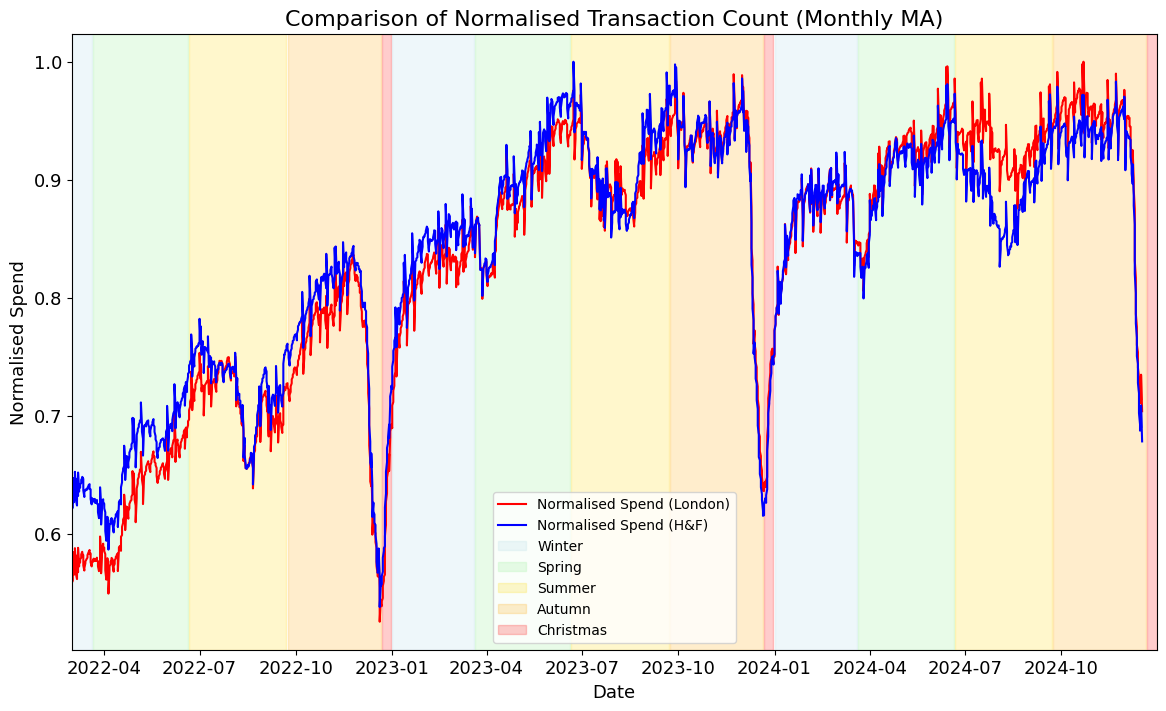

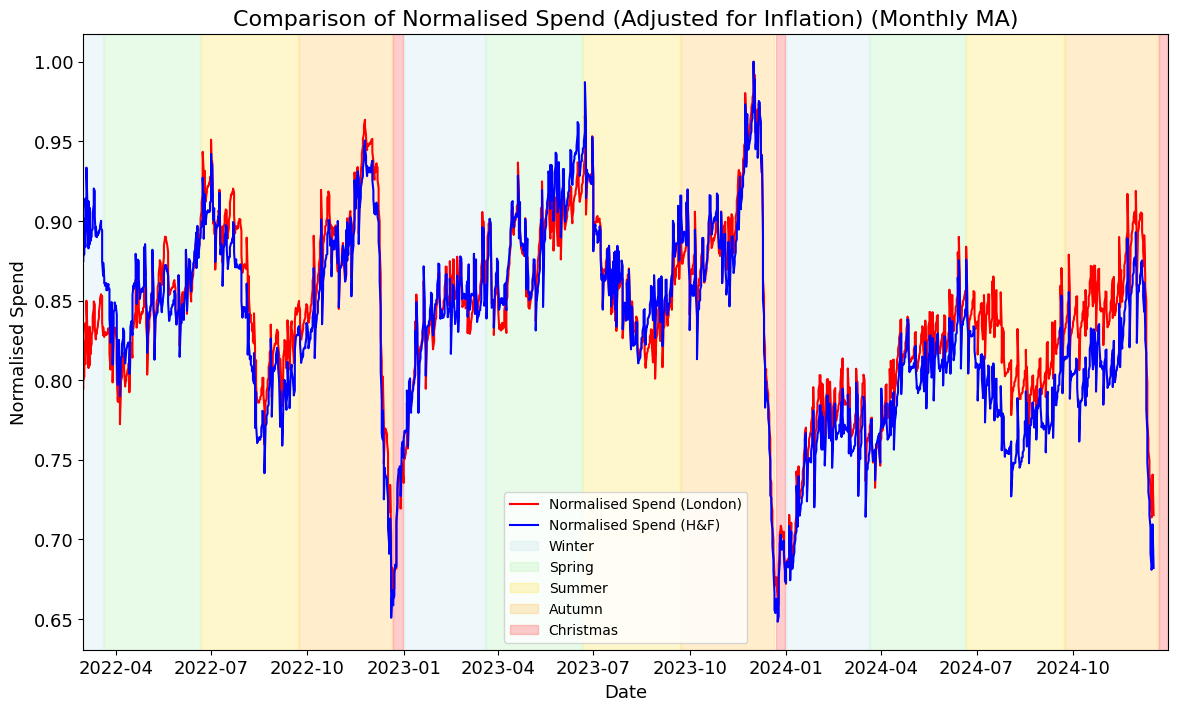

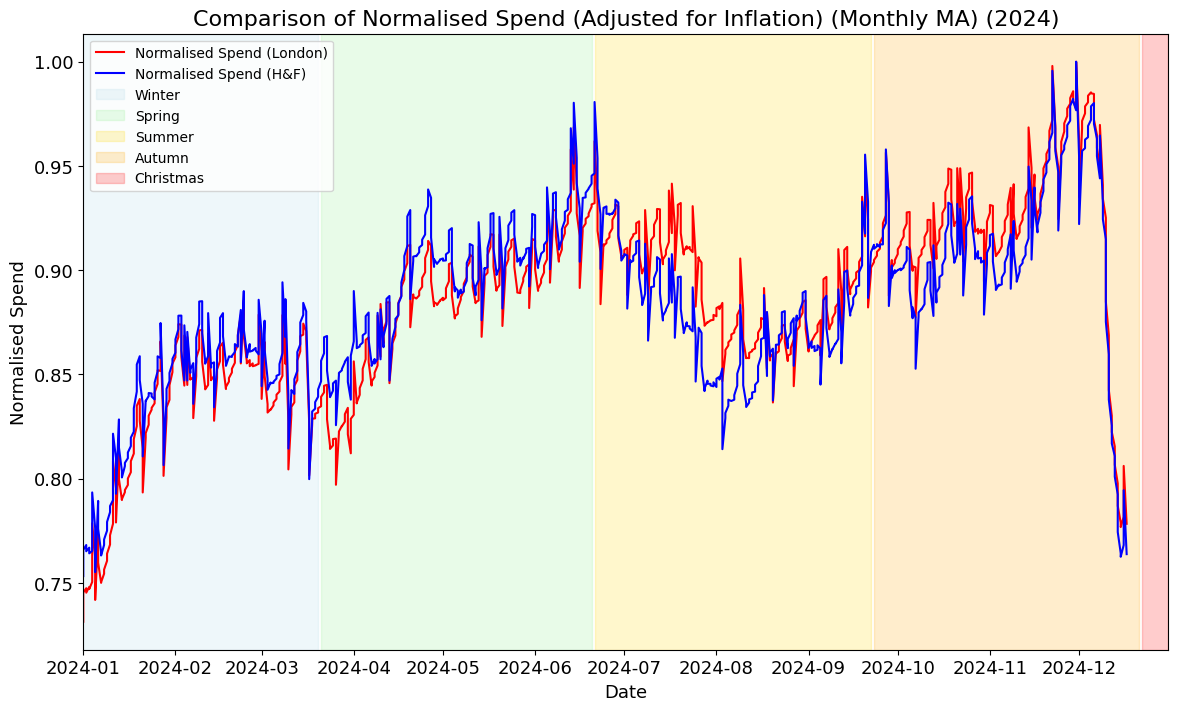

In [11]:
plot_spend(lon_spend_data, df2=lbhf_spend_data, category='normalized_cnt', agg='Transaction Count')
plot_spend(lon_spend_data, df2=lbhf_spend_data, category='normalized', agg='Spend (Adjusted for Inflation)')
plot_spend(lon_spend_data, df2=lbhf_spend_data, category='normalized', agg='Spend (Adjusted for Inflation)', year=2024)


DataFrame: aggregated_data


,day_name,Nighttime_mean,Daytime_mean
day_order,,,
0,Monday,8885.064898,24805.781918
1,Tuesday,9691.314221,25008.190572
2,Wednesday,10489.246619,25061.809157
3,Thursday,11523.162249,26056.529036
4,Friday,13981.044408,30159.191605
5,Saturday,13845.552194,34802.208054
6,Sunday,6359.647450,25699.838389


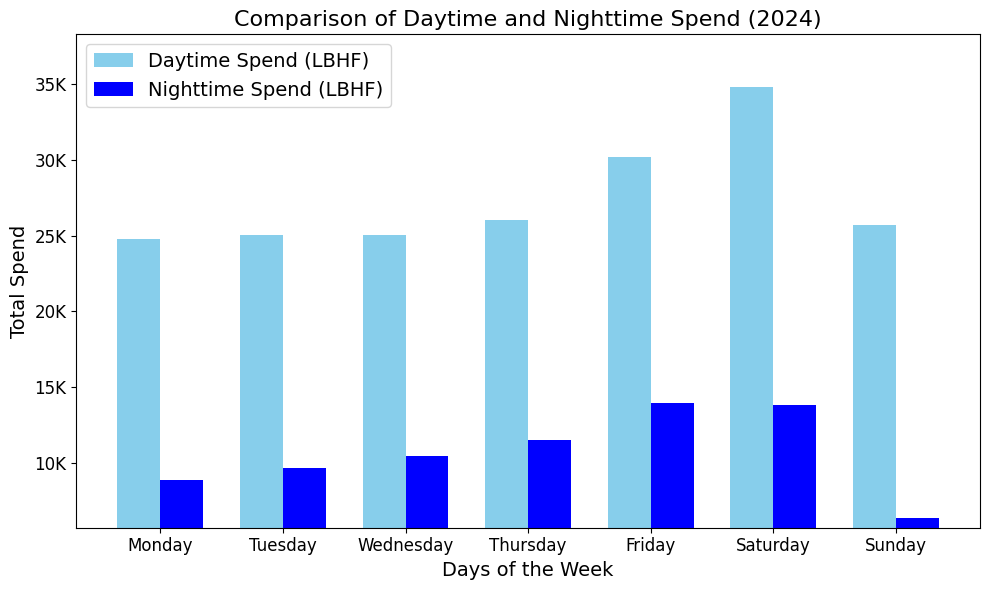

In [12]:
plot_daily_spend(lbhf_spend_data, year=2024, day_night=True)